In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
deepmd_jax_path = '../'           # Path to deepmd_jax package; change if you run this script at a different directory
precision       = 'default'       # 'default'(fp32), 'low'(mixed 32-16), 'high'(fp64)
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax, sys, os, datetime
import flax.linen as nn
from time import time
import matplotlib.pyplot as plt
from functools import partial
sys.path.append(os.path.abspath(deepmd_jax_path))
from deepmd_jax import data, utils
from deepmd_jax.dpmodel import DPModel
if precision == 'default':
    jax.config.update('jax_default_matmul_precision', 'float32')
if precision == 'high':
    jax.config.update('jax_enable_x64', True)
np.set_printoptions(precision=4, suppress=True)
print('# Program start at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 'on device:', jax.devices()[:1])

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


# Program start at 2023-11-24 19:31:35 on device: [cuda(id=0)]


# Model loaded from 'trained_models/new_dpmp_water_512.pkl'.
# Dataset loaded: 7797 frames/384 atoms. Path: 
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/water_128_shifted'
# Lattice vectors for neighbor images: Max 1 out of 1 condidates.
Mean force error = 0.0107
Mean energy error = 0.0277, Mean energy shift = -0.0129


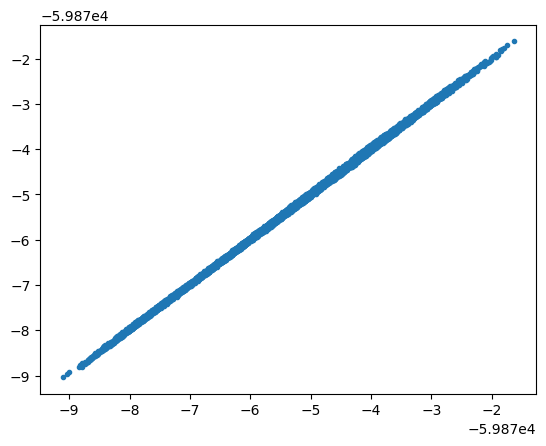

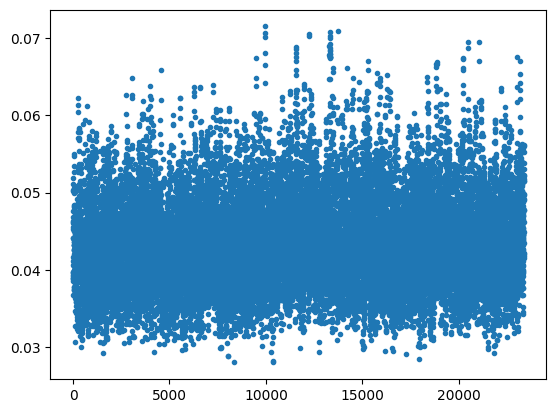

In [7]:
model_path       = 'trained_models/new_dpmp_water_512.pkl'
data_paths       = ['data/water_128_shifted']
# data_paths       = ['/pscratch/sd/r/ruiqig/polaron_cp2k/aimd/polaron_full_val']
test_batch_size  = 8
model, variables = utils.load_model(model_path)
dataset = data.DPDataset(data_paths, ['coord', 'box', 'force', 'energy'])
dataset.compute_lattice_candidate(model.params['rcut'])
force_true, force_pred, energy_true, energy_pred = [], [], [], []
e_and_f = jit(vmap(model.energy_and_force, in_axes=(None,0,0,None)), static_argnums=(3,))
dataset.pointer = 0
for i in range(dataset.nframes//test_batch_size):
    batch, type_count, lattice_args = dataset.get_batch(test_batch_size)
    static_args = nn.FrozenDict({'type_count':type_count, 'lattice': lattice_args})
    force_true.append(batch['force'])
    energy_true.append(batch['energy'])
    e, f = e_and_f(variables, batch['coord'], batch['box'], static_args)
    force_pred.append(np.array(f))
    energy_pred.append(np.array(e))
force_true = np.concatenate(force_true, axis=0)
force_pred = np.concatenate(force_pred, axis=0)
energy_true = np.concatenate(energy_true, axis=0)
energy_pred = np.concatenate(energy_pred, axis=0)
force_err = force_true - force_pred
energy_err = (energy_true - energy_pred)
print('Mean force error = %.4f' % (force_err**2).mean()**0.5)
print('Mean energy error = %.4f, Mean energy shift = %.4f' % (energy_err.std(), energy_err.mean()))
# plt.plot(force_true.flatten(), force_pred.flatten(), '.') # parity plot for force
# plt.savefig('force_parity.png')
plt.figure()
plt.plot(energy_true, energy_pred, '.') # parity plot for energy
plt.savefig('energy_parity.png')
plt.figure()
plt.plot(np.abs(force_err).max(1).flatten(), '.') # max error for each atom's force
plt.savefig('force_max_error.png')

In [6]:
# convert energy-force dataset to short range dataset; Used in DPLR
# source datasets should have the same type index; if not, run the code for each type index
# source_paths       = ['data/chunyi_dplr/data/energy_force_data/data/data' + str(i) for i in range(1,46)] \
#                    + ['data/chunyi_dplr/data/energy_force_data/data/data_ex' + str(i) for i in range(1,7)]
source_paths       = ['data/HCl/data/1water/']
target_path        = 'data/HCl/data/1water_sr'
# target_path        = 'data/chunyi_dplr/data/energy_force_data/data_sr'
wannier_model_path = 'trained_models/dw_hcl.pkl'
q_atoms            = [0, 1, 6, 0, 7]    # charge of atomic cores, here Oxygen and Hydrogen
q_wc               = [-8, -8]           # charge of wannier center/centroid
beta               = 0.4                # inverse spread of the point charge distribution
resolution         = 0.2                # particle mesh grid length = resolution / beta
model, variables = utils.load_model(wannier_model_path)
dataset = data.DPDataset(source_paths, ['coord','box','force','energy'])
dataset.compute_lattice_candidate(model.params['rcut'])
dataset.pointer = 0
batch, type_count, lattice_args = dataset.get_batch(1)
type_count = np.pad(type_count, (0,model.params['ntypes']-len(type_count)))
sel_type_count = tuple(np.array(type_count)[model.params['nsel']])
static_args = nn.FrozenDict({'type_count':type_count, 'lattice':lattice_args})
pred_fn = jit(model.apply, static_argnums=(3,))
qatoms = np.repeat(q_atoms, type_count)
qwc = np.repeat(q_wc, sel_type_count)
def lr_energy(coord, box, M):
    wc = model.wc_predict(variables, coord, box, static_args)
    p3mlr_fn = utils.get_p3mlr_fn(jnp.diag(box), beta, M)
    return p3mlr_fn(jnp.concatenate([coord, wc]), jnp.concatenate([qatoms, qwc])), wc
@partial(jit, static_argnums=(2,))
def lr_energy_and_force(coord, box, M):
    (e, wc), negf = value_and_grad(lr_energy, has_aux=True)(coord, box, M)
    return e, -negf, wc
dataset.pointer = 0
energy_lr, force_lr, wc = [], [], []
for i in range(dataset.nframes):
    M = utils.get_p3mlr_grid_size(np.diag(dataset.data['box'][i]), beta, resolution=resolution)
    e_lr, f_lr, wc_pred = lr_energy_and_force(dataset.data['coord'][i], dataset.data['box'][i], M)
    energy_lr.append(e_lr), force_lr.append(f_lr), wc.append(wc_pred)
energy_lr, force_lr, wc = np.array(energy_lr), np.array(force_lr), np.array(wc)
energy_full, force_full = dataset.data['energy'], dataset.data['force']
energy_sr, force_sr = energy_full - energy_lr, force_full - force_lr
utils.save_dataset(target_path, {'coord':dataset.data['coord'],
                                 'box':dataset.data['box'],
                                 'energy':energy_sr,
                                 'force':force_sr,
                                 'type': np.repeat(range(len(type_count)),type_count)})
# Print mean/std for sanity check
print('Energy (mean,std): Full (%.2f, %.2f) LR (%.2f, %.2f) SR (%.2f, %.2f) Ratio of std %.3f'
    % (energy_full.mean(), energy_full.std(), energy_lr.mean(), energy_lr.std(),
       energy_sr.mean(), energy_sr.std(), energy_sr.std()/energy_full.std()))
print('Force (mean,std): Full (%.2f, %.2f) LR (%.2f, %.2f) SR (%.2f, %.2f) Ratio of std %.3f'
    % (force_full.mean(), force_full.std(), force_lr.mean(), force_lr.std(),
         force_sr.mean(), force_sr.std(), force_sr.std()/force_full.std()))


# Model loaded from 'trained_models/dw_hcl.pkl'.
# Dataset loaded: 127 frames/3 atoms. Path: 
# 	'/global/u2/r/ruiqig/deepmd-jax/examples/data/HCl/data/1water'
# Lattice vectors for neighbor images: Max 1 out of 1 condidates.
Saved dataset with 127 frames to data/HCl/data/1water_sr
Energy (mean,std): Full (-466.92, 0.02) LR (0.12, 0.01) SR (-467.05, 0.02) Ratio of std 1.021
Force (mean,std): Full (0.00, 0.84) LR (0.00, 0.10) SR (-0.00, 0.85) Ratio of std 1.008
